In [3]:
import sys

import pandas as pd
import pdb
import os
import logging
from math import sin, cos, asin, sqrt, pi, radians
reload(logging)
import numpy as np

sys.path.append(os.path.join(os.getcwd(),os.pardir)) # add pardir to python path
from region_parameters import get_tibet_24x24_param
from generate_grid_and_area import grid_and_area
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode()
import plotly.graph_objs as go

import seaborn as sns
from matplotlib import rc
rc('text', usetex=False)
rc('font', family='monospace', size = 20)

colors = ["windows blue", "amber", "scarlet", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

/home/tyler/anaconda2/envs/tibet_env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [12]:
class grid_error(grid_and_area):
    
    def __init__(self,lat_long_coords,data_dir, no_snow_map_name, grid_size, plot_name):
        grid_and_area.__init__(self,lat_long_coords,data_dir, no_snow_map_name, grid_size)
        self.addLatLong(lat_grid_filename,lon_grid_filename)
        self.reduceLatLong()
        self.makeNoSnowMap()
        self.addAreas()
        self.plot_name = plot_name
        
    def get_surrounding_centroids(self,row_id):

        tl_point = self.df[ self.df['id'] == row_id]
        col, row = tl_point.index.values[0]
        centroid_corners = self.centroids.ix[(col, row)]['area_points']
        
        phi_1 = self.centroids.ix[centroid_corners['top_left']]['centroid_lat']
        lam_1 = self.centroids.ix[centroid_corners['top_left']]['centroid_long']
        
        phi_2 = self.centroids.ix[centroid_corners['top_right']]['centroid_lat']
        lam_2 = self.centroids.ix[centroid_corners['top_right']]['centroid_long']
        
        phi_3 = self.centroids.ix[centroid_corners['bottom_right']]['centroid_lat']
        lam_3 = self.centroids.ix[centroid_corners['bottom_right']]['centroid_long']

        phi_4 = self.centroids.ix[centroid_corners['bottom_left']]['centroid_lat']
        lam_4 = self.centroids.ix[centroid_corners['bottom_left']]['centroid_long']        
        
        return ((phi_1,lam_1),(phi_2,lam_2),(phi_3,lam_3),(phi_4,lam_4))
        
    def get_spherical_triangle(self,coords):       
        triangle_areas = []
        for i,coord in enumerate(coords):
            #print(i)
            #print((i+1)%4)
            start_coord = map(radians,coord)
            end_coord = map(radians,coords[(i+1)%4])
            phi_1, phi_2 = start_coord[0], end_coord[0]
            dist = self.haversine_formula(start_coord,end_coord)
            semi_p = self.semi_perimeter(dist, phi_1, phi_2)
            area = self.lhuilier(semi_p, dist, phi_1, phi_2)

            sign = 1 - 2*(i/2)       
            
            triangle_areas.append(area*sign)
        #pdb.set_trace()
        area = sum(triangle_areas)
        #print('area for {0}: {1}'.format(row_id, area))
        return area
    
    def spherical_polygon(self, coords):
        angles = []
        
        for i,coord in enumerate(coords):
            #print(i)
            #print((i+1)%4)
            start_coord = coord
            end_coord = coords[(i+1)%4]
            phi_1, phi_2 = start_coord[0], end_coord[0]
            dist = self.haversine_formula(start_coord,end_coord)   
            angles.append(dist)
        
        area = (sum(angles) - (len(coords) -2) * np.pi) * 6371**2
        pdb.set_trace()
        return area
    
    def haversine_formula(self,start_coord,end_coord):
        """
        Calculate the great circle distance between two points 
        on the earth (specified in decimal degrees)
        """
        # haversine formula 
        phi_1, lam_1 = start_coord
        phi_2, lam_2 = end_coord
        dlam = lam_2 - lam_1 
        dphi = phi_2 - phi_1 
        a_dist = sin(dphi/2)**2 + cos(phi_1) * cos(phi_2) * sin(dlam/2)**2
        dist = 2 * asin(sqrt(a_dist)) 
        return dist

    def semi_perimeter(self,dist, phi_1, phi_2):
        s = (dist  + pi  + (phi_1 + phi_2) )* .5
        return s
    
    def lhuilier(self,semi_p, dist, phi_1, phi_2): #uses unit sphere R=1
    
        inner_sq = np.sqrt( np.tan( 0.5*semi_p ) * 
                            np.tan( 0.5*(semi_p-dist) ) * 
                            np.tan( 0.5*(semi_p-(np.pi/2 + phi_1)) ) * 
                            np.tan( 0.5*(semi_p-(np.pi/2 + phi_2)) ) )
        Delta = 4.0 * np.arctan(inner_sq)
        
        area = 6371**2 * (Delta) #radius of earth is set at 6371 km 
        return area
        
    def get_cell_area(self,tri_top, tri_bot):
        area = tri_top - tri_bot
        return area
    
    def add_cell_area(self):
        
        
        def get_area(id_num):
            coord = self.get_surrounding_centroids(id_num)
            sp_area = self.get_spherical_triangle(coord)
            return sp_area
        
        self.df['sp_area'] = map(lambda x: get_area(x), self.df['id'])
        self.df['area_error'] = 100* (self.df['area'] - self.df['sp_area']) / self.df['sp_area']
    #def compare_cell_area():
    
    def plot_dist(self, save = True):
        fig = plt.figure(0)
        axes = plt.axes()
        axes.hist(self.df['area_error'].values, 50)
        axes.set_title('histogram of error')
        axes.set_ylabel(r'frequency')
        axes.set_xlabel(r'% error')
        plt.show()
        if save:
            plt.savefig(self.plot_name)
    
    def color_plot(self):
        
        df = self.df.reset_index(level = self.df.index.names, inplace=False)
        
        def make_whole_area_text(X):
            return 'Area error: %s\
            <br>LEAP area: %s\
            <br>sph tri area: %s\
            <br>row: %s\
            <br>column: %s\
            <br>lat: %s\
            <br>long: %s\
            <br>id: %s'\
            % (round(X['area_error'],4),
               round(X['area'],2),
               round(X['sp_area'],2),
               X['row'],
               X['col'],
               round(X['lat'],3),
               round(X['long'],3),X['id']) 
        
        scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[0,"rgb(220, 220, 220)"] ]
        trace = go.Scattergl(
                x = df['long'],
                y = df['lat'],
                text =df.apply(lambda x: make_whole_area_text(x), axis=1),
                mode = 'markers',
                marker = dict( 
                    size = 8, 
                    opacity = 0.8,
                    reversescale = True,
                    autocolorscale = False,
                    symbol = 'dot',
                    line = dict(
                        width=0,
                        color='rgba(102, 102, 102)'),
                    colorscale = scl,
                    cmin = df['area_error'].min(),
                    color = df['area_error'],
                    cmax = df['area_error'].max(),
                    colorbar=dict(
                        title="%")
                    )
                )
        
        data = [trace]
        layout = dict(
                title = 'Area Error of {0}'.format(self.plot_name),
                colorbar = True,  
                xaxis=dict(
                title='Longitude',
                titlefont=dict(
                    family='Courier New, monospace',
                    size=22
                    ),
                tickfont=dict(
                    size = 14
                    ),
                ),
                yaxis=dict(
                    title='Latitude',
                    titlefont=dict(
                        family='Courier New, monospace',
                        size=22
                        ),
                    tickfont=dict(
                        size = 14
                        ),
                    ),
                )
            
        
        fig_color_plot = dict( data=data, layout=layout )
        plot_url = iplot(fig_color_plot, validate=False)

In [13]:

home_dir = os.getcwd()

data_dir = os.path.join(os.path.join(os.getcwd(),os.pardir,os.pardir), 'data')
#data_dir = os.path.abspath(os.path.join(os.getcwd() , os.pardir, 'data'))

input_dict = get_tibet_24x24_param()
ftp_filename = input_dict['ftp_filename']
grid_size = input_dict['grid_size']
no_snow_planet_name = input_dict['no_snow_planet_name']
lat_grid_filename = input_dict['lat_grid_filename']
lon_grid_filename = input_dict['lon_grid_filename']
lat_long_area_filename = input_dict['lat_long_area_filename']
lat_long_coords = input_dict['lat_long_coords']
plot_name = input_dict['filename']

#initialize object
ge = grid_error(lat_long_coords,data_dir,no_snow_planet_name,grid_size,plot_name)
coords_0 = ge.get_surrounding_centroids(0)

#add spherical triangle areas to dataframe
ge.add_cell_area()



inside get_tibet_24x24_param


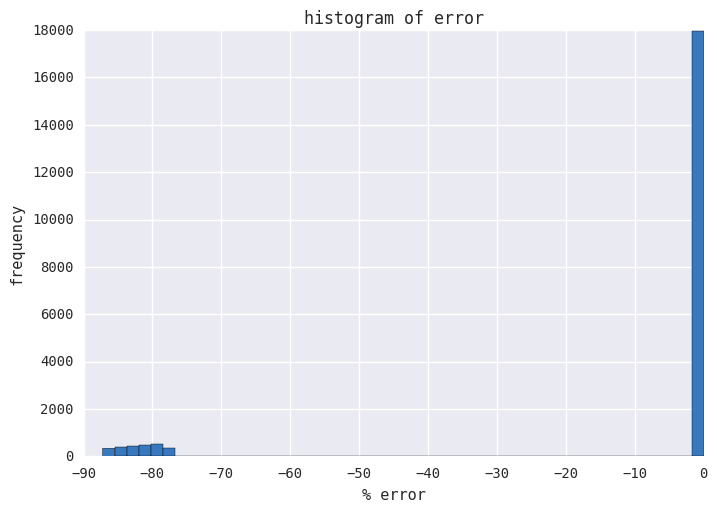

In [7]:
#plot errors

ge.plot_dist(save = True)


In [14]:
#plot errors
#ge.plot_dist(save = True)
ge.color_plot()